# Lowering the jet $p_T$

**Goal:** Get Max to put the tatoo on his face!


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import itertools
import h5py

import uproot

import os
os.sys.path.append('../code')
from AnalysisUtils import nanoToDf, getExpectedBand, getBkgSysBand
from AnalysisUtils import getLambdaWeights, hackHistogram, getHelicityAnglesRR
from plotting import sig_bkg_massplanes, plot_MDpT, plot2dSig, plotSigBkg
from analysis import read_tsv

os.sys.path.append('../eda_tools')
from NN_RW import getNNweights

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load in the files**

In [2]:
fDir = "../../hh4b/hh4b-resolved-reconstruction" 

lumi15 = 3.2195
lumi16 = 24.5556
lumi = lumi15+lumi16

sdf = nanoToDf(f"{fDir}/sm_pT20.root",   ttree="fullmassplane")
bdf = nanoToDf(f"{fDir}/dat16_pT20.root",ttree="fullmassplane")

sdf['mc_sf'] *= lumi

fullmassplane
fullmassplane


In [3]:
jpT_cols = ['pT_h1_j1', 'pT_h1_j2', 'pT_h2_j1', 'pT_h2_j2']

In [4]:
for df in [sdf, bdf]:
    
    df['pT_category'] = -1
    min_pTs = np.min( df[jpT_cols], axis=1 )
    
    masks = [(min_pTs > 40),
             (min_pTs > 30) & (min_pTs < 40),
             (min_pTs > 20) & (min_pTs < 30)]
    
    for k, m in enumerate(masks):
        df.loc[m,'pT_category'] = k

In [52]:
np.min(sdf[jpT_cols])

pT_h1_j1    28.565403
pT_h1_j2    25.005316
pT_h2_j1    28.539202
pT_h2_j2    25.000191
dtype: float64

Ok, let's start by just getting the $m_{hh}$ histograms w/o any reweighting

In [53]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])
x = 0.5*(edges[:-1]+edges[1:])

labels = ['min jet $p_T$ > 40 GeV', 'min jet 30 GeV < $p_T$ < 40 GeV', 'min jet 25 GeV < $p_T$ < 30 GeV']
yields = pd.DataFrame(0,index=['$s$','$b$','$s/\sqrt{b}$', '$s/b$'],columns=labels)

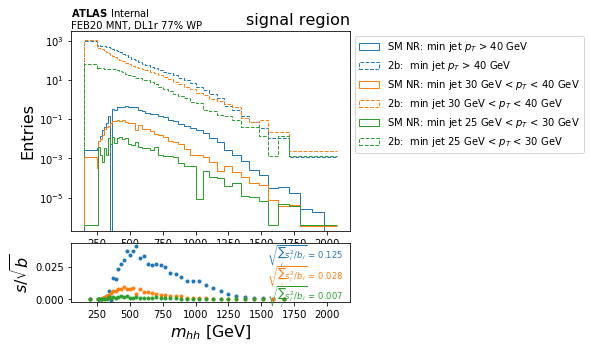

In [54]:
# # Make the mhh histogram for the signal
# fig = plt.figure(figsize=(5, 5))
# gs = gridspec.GridSpec(4,1)
# ax1 = fig.add_subplot(gs[:3,0])
# ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

# for k, label,ytxt in zip(range(3), labels, [1, 0.65, 0.3]):

#     color = f'C{k}'
    
#     # signal
#     sig_mask = (sdf.ntag>=4) & (sdf.kinematic_region==0) & (sdf.pT_category == k)
#     si,_,_ = ax1.hist(sdf.loc[sig_mask,'m_hh'],
#                       edges,color=color,histtype='step',log=True,
#                       label="SM NR: "+label,ls='-',
#                       weights=sdf.loc[sig_mask,'mc_sf'])

#     # background
#     bkg_mask = (bdf.ntag==2) & (bdf.kinematic_region==0) & (bdf.pT_category == k)
    
#     # For now - let's do a scaling
#     N2b = np.sum((bdf.ntag==2) & (bdf.kinematic_region==2) & (bdf.pT_category == k)) 
#     N4b = np.sum((bdf.ntag>=4) & (bdf.kinematic_region==2) & (bdf.pT_category == k))
    
#     bi,_,_ = ax1.hist(bdf.loc[bkg_mask,'m_hh'],
#                       edges,color=color,histtype='step',log=True,
#                       label="2b:  "+label,ls='--',
#                       weights=(N4b/N2b)*bdf.loc[bkg_mask,'mc_sf'])

#     # Significance (it probably would be a good idea to put mv2 and dl1r in different subpanels)
#     ax2.plot(x[bi!=0],si[bi!=0]/np.sqrt(bi[bi!=0]),marker='.',color=color,linewidth=0)

#     sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

#     ax2.text(.975,ytxt,sigText+'{:.3f}'.format(np.sqrt(np.sum(si[bi!=0]**2 / bi[bi!=0]))),
#              ha='right',va='top',fontsize=8.5,
#              transform=ax2.transAxes,color=color)

#     yields.loc['$s$',label] = np.sum(si)
#     yields.loc['$b$',label] = np.sum(bi)
#     yields.loc['$s/b$',label] = np.sum(si) / np.sum(bi)
#     yields.loc['$s/\sqrt{b}$',label] = np.sum(si) / np.sqrt(np.sum(bi))

#     # Calculate the limit
# #     band = getExpectedBand(si,bi,mu_tests)
# #     stats.loc[bidx,label] = band
    
# # Text per subfig
# ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

# # Make the plot pretty
# ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
# ax1.set_ylabel('Entries', fontsize=16)
# ax1.set_title('signal region', loc='right',fontsize=16)
# ax1.legend(bbox_to_anchor=(1,1))

# ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

# #plt.savefig('figures/dl1r_77/m_hh_SR_mdr_vs_bdt.pdf',bbox_inches='tight')

# plt.show()

**Open question:** Does this 20 GeV < $p_T$ < 30 GeV help at all?

For the SM, it honestly doesn't look like it - but I think I should check the $\kappa_\lambda$ limit before throwing it out!

**New plan:** I'm going to use Sean's "latest-and-greatest" NN reweighting for this week of studies :)


In [8]:
sdf.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'm_hh_cor', 'm_hh', 'pt_hh', 'dEta_hh', 'X_wt',
       'X_wt_2', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2',
       'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1',
       'm_h1_j2', 'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'quantile_h1_j2', 'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1',
       'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1',
       'm_h2_j2', 'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'pT_category'],
      dtype='object')

In [9]:
np.sqrt(.125**2+.028**2)/.125**2

8.198247617631466

In [10]:
311164 / 6

51860.666666666664

In [11]:
# Compare the yields in the SR
yields.round(2)

min jet $p_T$ > 40 GeV  min jet 30 GeV < $p_T$ < 40 GeV  \
$s$                             5.64                             1.07   
$b$                          7480.01                          4695.06   
$s/\sqrt{b}$                    0.07                             0.02   
$s/b$                           0.00                             0.00   

              min jet 20 GeV < $p_T$ < 30 GeV  
$s$                                      0.13  
$b$                                    659.19  
$s/\sqrt{b}$                             0.01  
$s/b$                                    0.00

In [12]:
# si,_,_ = plt.hist(sdf.loc[sig_mask,'m_hh'],
#                   edges,color=color,histtype='step',log=True,
#                   label="SM NR: "+label,ls='-',
#                   weights=sdf.loc[sig_mask,'mc_sf'])

In [13]:
# np.sum(bkg_mask)

In [14]:
np.max(df.pT_category)

2

## Train the background estimates

In [59]:
# Derive the new variables that Sean suggested
bdf['dPhi_h1'] = np.arccos(np.cos(bdf.phi_h1_j1 - bdf.phi_h1_j2))
bdf['dPhi_h2'] = np.arccos(np.cos(bdf.phi_h2_j1 - bdf.phi_h2_j2))

bdf['dPhi_hh'] = np.arccos(np.cos(bdf.phi_h1 - bdf.phi_h2))
bdf['dR_hh'] = np.sqrt( bdf['dPhi_hh']**2 + (bdf.eta_h1 - bdf.eta_h2)**2 )

In [17]:
np.min(bdf.dPhi_hh),np.max(bdf.dPhi_hh)

(4.921896626029584e-07, 3.141592653589793)

In [19]:
sort_rw_cols=['pT_4_log', 'pT_2_log','eta_i', 'dRjj_1_log', 'dRjj_2_log', 
              'njets', 'pt_hh_log', 'X_wt_log', 'dR_hh', 'dPhi_h1', 'dPhi_h2']

pTs = [40,30,20]
nHiddens = [10,20,30,40,50]

In [61]:
# Lowering pT w/ hp scan over hidden units
min_val_loss = {}

for k, pT in enumerate(pTs):
    
    # Add a new key to the dictionary
    key = f'pT_{pT}'
    min_val_loss[key] = []
    
    for nHidden in [50]:
        
        modelName = f"models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_{pT}_nHidden_{nHidden}.h5"
            
        mask = (bdf.pT_category == k)
            
        getNNweights(bdf, mask=mask, kinematic_region=2,
                     sort_rw_cols=sort_rw_cols, nHidden=nHidden,
                     epochs = 80, patience=10, train=True, 
                     key=f"w_2b_pT_{pT}_nHidden_{nHidden}", 
                     modelName=modelName)
        
        # Load the min val loss
        historyName = modelName[:-3]+"_history.h5"
            
        h = h5py.File(historyName,"r")

        vl = np.min(h['val_loss'][:])
        min_val_loss[key].append(vl)

        h.close()
        

Train on 828014 samples, validate on 207004 samples
Epoch 1/80
828014/828014 [==============================] - 4s 5us/step - loss: 0.3704 - acc: 0.0029 - val_loss: 0.2230 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.22297, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_40_nHidden_50.h5
Epoch 2/80
828014/828014 [==============================] - 2s 2us/step - loss: 0.2111 - acc: 0.0000e+00 - val_loss: 0.2121 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.22297 to 0.21214, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_40_nHidden_50.h5
Epoch 3/80
828014/828014 [==============================] - 3s 3us/step - loss: 0.2049 - acc: 0.0000e+00 - val_loss: 0.2086 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.21214 to 0.20865, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_40_nHidden_50.h5
Epoch 4/80
828014/828014 [==============================] - 4s 5us/step - loss: 0.2019 - acc: 0.0000e+00 - val_loss:


Epoch 00007: val_loss improved from 0.22927 to 0.22823, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_30_nHidden_50.h5
Epoch 8/80
204808/204808 [==============================] - 1s 3us/step - loss: 0.2350 - acc: 0.0030 - val_loss: 0.2271 - val_acc: 0.0030

Epoch 00008: val_loss improved from 0.22823 to 0.22706, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_30_nHidden_50.h5
Epoch 9/80
204808/204808 [==============================] - 1s 3us/step - loss: 0.2343 - acc: 0.0030 - val_loss: 0.2266 - val_acc: 0.0028

Epoch 00009: val_loss improved from 0.22706 to 0.22663, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_30_nHidden_50.h5
Epoch 10/80
204808/204808 [==============================] - 1s 3us/step - loss: 0.2345 - acc: 0.0026 - val_loss: 0.2267 - val_acc: 0.0035

Epoch 00010: val_loss did not improve from 0.22663
Epoch 11/80
204808/204808 [==============================] - 1s 3us/step - loss: 0.2348 - acc: 0.0034 - val_loss: 0.2263 - val_acc:

204808/204808 [==============================] - 1s 3us/step - loss: 0.2215 - acc: 0.0030 - val_loss: 0.2219 - val_acc: 0.0026

Epoch 00042: val_loss did not improve from 0.22039
Epoch 43/80
204808/204808 [==============================] - 1s 3us/step - loss: 0.2216 - acc: 0.0031 - val_loss: 0.2209 - val_acc: 0.0036

Epoch 00043: val_loss did not improve from 0.22039
Epoch 44/80
204808/204808 [==============================] - 1s 3us/step - loss: 0.2331 - acc: 0.0047 - val_loss: 0.2262 - val_acc: 0.0032

Epoch 00044: val_loss did not improve from 0.22039
Epoch 45/80
204808/204808 [==============================] - 1s 3us/step - loss: 0.2282 - acc: 0.0032 - val_loss: 0.2228 - val_acc: 0.0028

Epoch 00045: val_loss did not improve from 0.22039
Epoch 00045: early stopping
Saving history object
rw 2b yield 6199.008
4b yield 5809
Train on 64901 samples, validate on 16226 samples
Epoch 1/80
64901/64901 [==============================] - 2s 37us/step - loss: 0.8289 - acc: 0.0039 - val_loss: 0


Epoch 00028: val_loss did not improve from 0.11680
Epoch 29/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0960 - acc: 0.0035 - val_loss: 0.1170 - val_acc: 0.0034

Epoch 00029: val_loss did not improve from 0.11680
Epoch 30/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0954 - acc: 0.0035 - val_loss: 0.1151 - val_acc: 0.0033

Epoch 00030: val_loss improved from 0.11680 to 0.11508, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_20_nHidden_50.h5
Epoch 31/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0948 - acc: 0.0034 - val_loss: 0.1159 - val_acc: 0.0031

Epoch 00031: val_loss did not improve from 0.11508
Epoch 32/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0944 - acc: 0.0034 - val_loss: 0.1139 - val_acc: 0.0032

Epoch 00032: val_loss improved from 0.11508 to 0.11386, saving model to models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_20_nHidden_50.h5
Epoch 33/80
64901/64901 [===


Epoch 00065: val_loss did not improve from 0.10687
Epoch 66/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0815 - acc: 0.0030 - val_loss: 0.1090 - val_acc: 0.0023

Epoch 00066: val_loss did not improve from 0.10687
Epoch 67/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0811 - acc: 0.0030 - val_loss: 0.1087 - val_acc: 0.0024

Epoch 00067: val_loss did not improve from 0.10687
Epoch 68/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0810 - acc: 0.0030 - val_loss: 0.1088 - val_acc: 0.0025

Epoch 00068: val_loss did not improve from 0.10687
Epoch 69/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0805 - acc: 0.0030 - val_loss: 0.1069 - val_acc: 0.0024

Epoch 00069: val_loss did not improve from 0.10687
Epoch 70/80
64901/64901 [==============================] - 0s 3us/step - loss: 0.0804 - acc: 0.0031 - val_loss: 0.1099 - val_acc: 0.0025

Epoch 00070: val_loss did not improve from 0.10687
Epo

It would be really nice to compare the training and validation losses for these models that I've trained.

In [38]:
text = '$\mathbf{ATLAS}$ 2016 data Internal\n'
text += 'FEB20 MNT, NNT mod from MAR20.2\n'
text += 'DL1r at 77% WP, MDR + min $D_{hh}$'

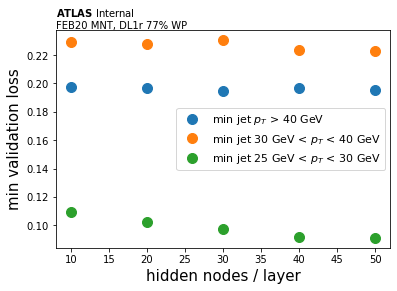

In [55]:
plt.figure()

for pT, l in zip([40,30,20],labels):

    key = f'pT_{pT}'
    plt.plot(nHiddens,min_val_loss[key],label=l,
             marker='.',markersize=20,linewidth=0)
    
plt.xlabel('hidden nodes / layer',fontsize=15)
plt.ylabel('min validation loss',fontsize=15)
plt.legend(fontsize=11)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/dl1r_77/rw_figs/min_val_loss_pT_cat.pdf',bbox_inches='tight')
        
plt.show()

In [26]:
min_val_loss['pT_30']

[0.22924532197258532,
 0.22810631740561893,
 0.23045688270102338,
 0.22350376662896174,
 0.22256826366443103]

For completeness, I could also consider plotting the training losses for the selected models?

Also make a table including the 2b, 3b, and 4b yeilds for each of these $p_T$ categories in the SR, CR, and SB.

Now let's *sanity check* the reweightings for the chosen hyperparameters for each of these regions.

In [53]:
np.max(bdf.dphi_hh)

6.278227656931344

In [63]:
bdf.loc[(bdf.kinematic_region==2) & (bdf.pT_category == 2),'pT_4']

entry
53         25.993338
70         27.089968
148        28.713692
152        26.197184
155        27.486176
             ...    
8501658    25.595760
8501691    29.567526
8501767    25.276129
8501847    26.280811
8502002    27.428690
Name: pT_4, Length: 89910, dtype: float64

In [49]:
rw_vars = ['njets','pT_4', 'pT_2', 'dRjj_1', 'dRjj_2','eta_i','pt_hh',
           'X_wt', 'dR_hh', 'dPhi_h1', 'dPhi_h2','m_hh']
nBins = [8]+[50]*11
myRanges = [(3.5,12.5),(0,125),(0,200),(0,4),(0,4),(0,2.5),(0,400),
            (0,10),(0,2*np.pi),(0,np.pi),(0,np.pi),(0,1250)]

In [189]:
regions = ['SR','VR','CR']
short_labels = ['$p_T$ > 40 GeV', '$p_T \in$ (30,40) GeV',  '$p_T \in$ (25,30) GeV']

bkg_yield = pd.DataFrame(0, [f'{nb}b {r}' for nb in [2,3,4] for r in regions], short_labels)

for k, l in enumerate(short_labels):
    for r, region in enumerate(['SR','VR','CR']):
        mask = (bdf.kinematic_region==r) & (bdf.pT_category == k) 
        
        bkg_yield.loc[f'2b {region}',l] = np.sum(mask & (bdf.ntag==2))
        
        if r != 0:

            bkg_yield.loc[f'3b {region}',l] = np.sum(mask & (bdf.ntag==3))
            bkg_yield.loc[f'4b {region}',l] = np.sum(mask & (bdf.ntag>=4))

In [186]:
l

'$p_T \\in$ (25,30) GeV'

In [190]:
bkg_yield

$p_T$ > 40 GeV  $p_T \in$ (30,40) GeV  $p_T \in$ (25,30) GeV
2b SR          645298                 202223                  49320
2b VR          717541                 201033                  56315
2b CR         1023158                 250202                  80057
3b SR               0                      0                      0
3b VR           82697                  31237                   6250
3b CR          121421                  40834                   8783
4b SR               0                      0                      0
4b VR            8137                   4774                    901
4b CR           11860                   5809                   1070

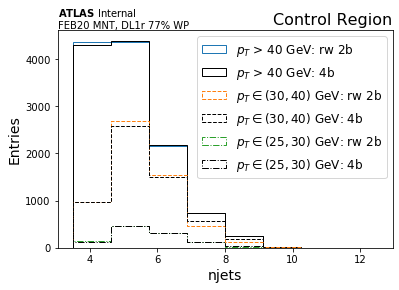

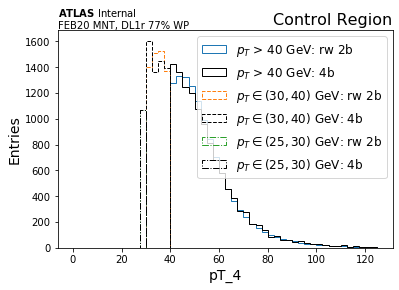

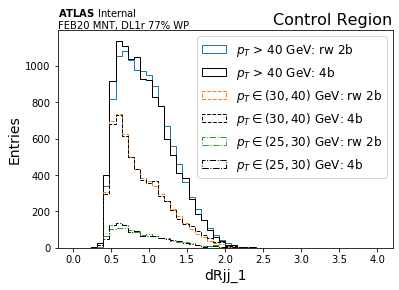

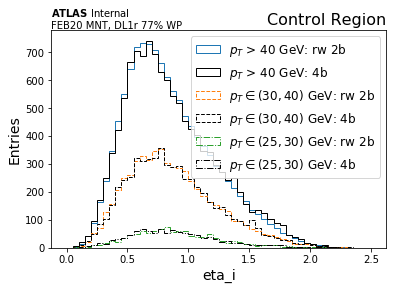

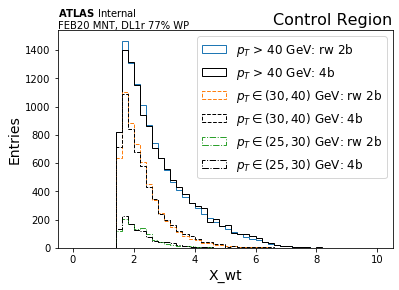

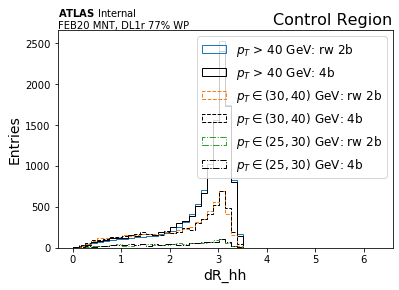

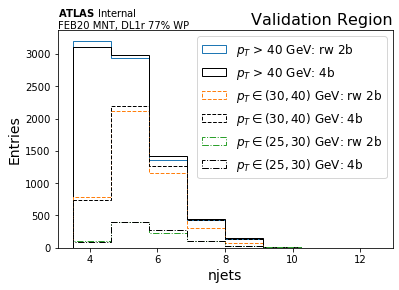

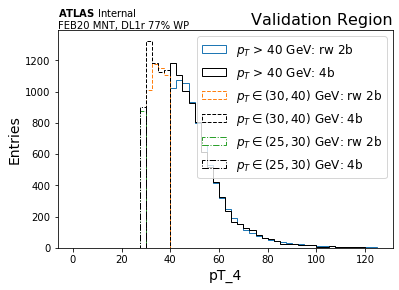

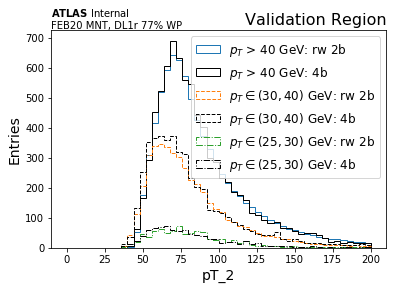

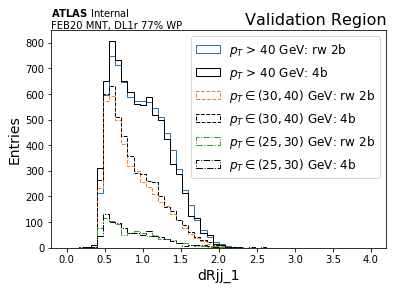

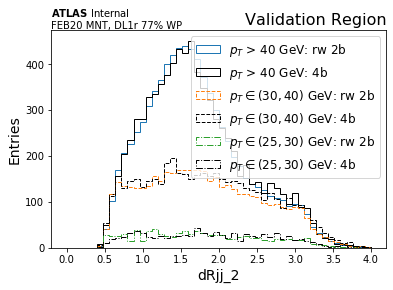

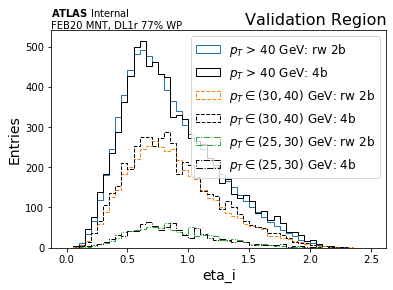

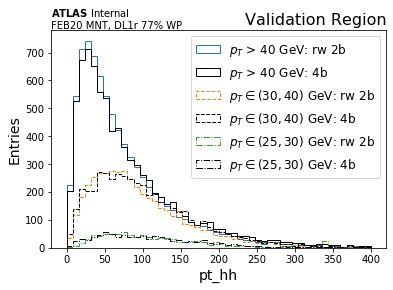

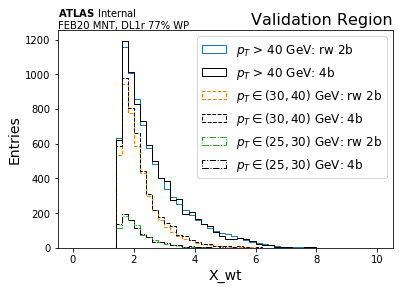

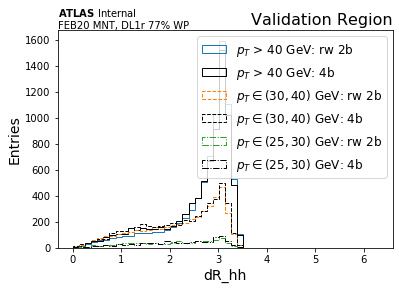

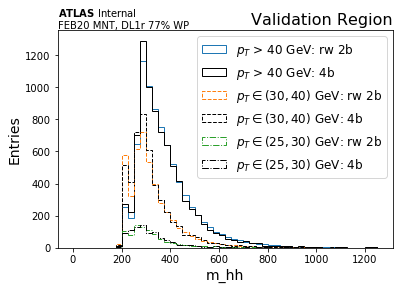

In [62]:
nHi = 50

for region, title,tag in zip([2,1],['Control Region','Validation Region'],['CR','VR']):
    
    for c,n,r in zip(rw_vars,nBins,myRanges):

        plt.figure()
        
        for k, pT, l, color, ls in zip(range(3),[40,30,20],short_labels,
                                       ['C0','C1','C2'],['-','--','-.']):
        
            mask = (bdf.kinematic_region==region) & (bdf.pT_category == k)
            w2b = f'w_2b_pT_{pT}_nHidden_{nHi}'
            
            plt.hist(bdf.loc[(bdf.ntag==2) & mask,c], 
                     n, r, color=color, linestyle=ls,
                     histtype='step',label=l+': rw 2b',
                     weights=bdf.loc[(bdf.ntag==2) & mask, w2b])

            plt.hist(bdf.loc[(bdf.ntag>=4) & mask,c],
                     n,r,color='k',linestyle=ls,
                     histtype='step',label=l+': 4b')
        
        plt.xlabel(c,fontsize=14)
        plt.ylabel('Entries',fontsize=14)
        plt.legend(fontsize=12)
        plt.title(title,loc='right',fontsize=16)

        ax = plt.gca()
        plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

        plt.savefig(f'figures/dl1r_77/rw_figs/pTCat_{c}_cf_deta_hh_cut_{tag}.pdf',bbox_inches='tight')
        plt.show()



In [109]:
labels = ['jet $p_T$ > 40 GeV', 'min jet $p_T \in (30,40)$ GeV', 'min jet $p_T \in (25,30)$ GeV']
yields = pd.DataFrame(0,index=['$s$','$b$','$s/\sqrt{b}$', '$s/b$'],columns=labels)

bidx = ['$-2\sigma$','$-\sigma$','exp','$+\sigma$', '$+2\sigma$']
mu_tests = np.linspace(1,50, 50)

stats_labels = ['jet $p_T$ > 40 GeV', 'jet $p_T$ > 30 GeV', 'jet $p_T$ > 25 GeV']
stats = pd.DataFrame(0, index=bidx, columns=stats_labels)

stats_cat = pd.DataFrame(0, index=bidx, columns=stats_labels)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)
../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1160: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inlin

5.640649515199514 7139.445719166426


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1160: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value enc

1.0731499404828437 4434.718853695347


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1160: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value enc

0.13022467929184817 831.5946200039472


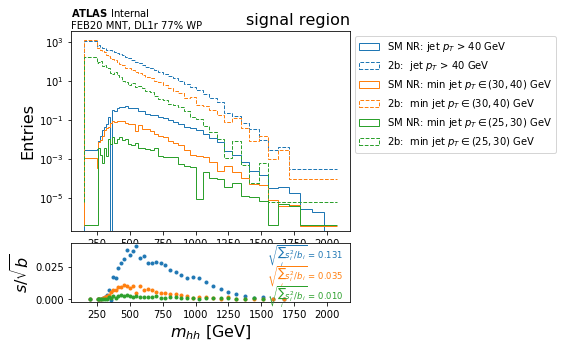

In [110]:
# Make the mhh histogram for the signal
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

s,b = [],[]
s_cat, b_cat = [],[]

for k, label, l, pT, ytxt in zip(range(3), labels, stats_labels, pTs, [1, 0.65, 0.3]):

    color = f'C{k}'
    
    # signal
    sig_mask = (sdf.ntag>=4) & (sdf.kinematic_region==0) & (sdf.pT_category == k)
    si,_,_ = ax1.hist(sdf.loc[sig_mask,'m_hh'],
                      edges,color=color,histtype='step',log=True,
                      label="SM NR: "+label,ls='-',
                      weights=sdf.loc[sig_mask,'mc_sf'])

    # background
    bkg_mask = (bdf.ntag==2) & (bdf.kinematic_region==0) & (bdf.pT_category == k)
    w2b = f'w_2b_pT_{pT}_nHidden_50'
    
    bi,_,_ = ax1.hist(bdf.loc[bkg_mask,'m_hh'],
                      edges,color=color,histtype='step',log=True,
                      label="2b:  "+label,ls='--',
                      weights=bdf.loc[bkg_mask,w2b])

    # Significance (it probably would be a good idea to put mv2 and dl1r in different subpanels)
    ax2.plot(x[bi!=0],si[bi!=0]/np.sqrt(bi[bi!=0]),marker='.',color=color,linewidth=0)

    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

    ax2.text(.975,ytxt,sigText+'{:.3f}'.format(np.sqrt(np.sum(si[bi!=0]**2 / bi[bi!=0]))),
             ha='right',va='top',fontsize=8.5,
             transform=ax2.transAxes,color=color)

    yields.loc['$s$',label] = np.sum(si)
    yields.loc['$b$',label] = np.sum(bi)
    yields.loc['$s/b$',label] = np.sum(si) / np.sum(bi)
    yields.loc['$s/\sqrt{b}$',label] = np.sum(si) / np.sqrt(np.sum(bi))

    # Calculate the limit
    s += list(si)
    b += list(bi)
    
    band = getExpectedBand(s, b, mu_tests)
    stats.loc[bidx,l] = band
    
    # also do the cos(theta*) categorization    
    sj,bj  = plot2dSig(sdf[sig_mask], bdf[bkg_mask], 'm_hh', 'cosThetaStar',
                       nBins, None, w2b=w2b, smText='', dataText='',
                       ylabel='$|\cos \Theta^*|$',
                       figDir='figures/dl1r_77',tag=f'_pT_{pT}')
    
    s_cat += list(sj.T.reshape(-1))
    b_cat += list(bj.T.reshape(-1))
    
    band = getExpectedBand(s_cat, b_cat, mu_tests)
    stats_cat.loc[bidx,l] = band
    
# Text per subfig
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

# Make the plot pretty
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
ax1.set_ylabel('Entries', fontsize=16)
ax1.set_title('signal region', loc='right',fontsize=16)
ax1.legend(bbox_to_anchor=(1,1))

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('figures/dl1r_77/m_hh_SR_pTCat.pdf',bbox_inches='tight')

plt.show()

In [88]:
yields

jet $p_T$ > 40 GeV  min jet $p_T \in (30,40)$ GeV  \
$s$                     5.640650                       1.073150   
$b$                  7139.445312                    4434.704590   
$s/\sqrt{b}$            0.066757                       0.016115   
$s/b$                   0.000790                       0.000242   

              min jet $p_T \in (25,30)$ GeV  
$s$                                0.130225  
$b$                              831.566101  
$s/\sqrt{b}$                       0.004516  
$s/b$                              0.000157

In [113]:
stats.round(1)

jet $p_T$ > 40 GeV  jet $p_T$ > 30 GeV  jet $p_T$ > 25 GeV
$-2\sigma$                 8.2                 7.9                 7.9
$-\sigma$                 11.0                10.6                10.6
exp                       15.3                14.8                14.7
$+\sigma$                 21.5                20.7                20.6
$+2\sigma$                29.0                28.0                27.9

In [123]:
len(s)/3

45.0

In [125]:
s_tot = list(np.array(s[:45]) + np.array(s[45:90]))
b_tot = list(np.array(b[:45]) + np.array(b[45:90]))

band = getExpectedBand(s_tot, b_tot, mu_tests)
stats.loc[bidx,'Inclusive with $p_T$ > 30 GeV'] = band

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [127]:
stats.round(2)

jet $p_T$ > 40 GeV  jet $p_T$ > 30 GeV  jet $p_T$ > 25 GeV  \
$-2\sigma$                8.16                7.88                7.86   
$-\sigma$                10.97               10.62               10.59   
exp                      15.33               14.78               14.74   
$+\sigma$                21.48               20.71               20.65   
$+2\sigma$               29.02               27.96               27.89   

            Inclusive with $p_T$ > 30 GeV  
$-2\sigma$                           8.15  
$-\sigma$                           10.95  
exp                                 15.28  
$+\sigma$                           21.39  
$+2\sigma$                          28.87

In [115]:
stats_cat

jet $p_T$ > 40 GeV  jet $p_T$ > 30 GeV  jet $p_T$ > 25 GeV
$-2\sigma$            7.105038            6.847999            6.801811
$-\sigma$             9.618001            9.243296            9.167597
exp                  13.444939           12.911990           12.831458
$+\sigma$            18.886264           18.163441           18.029087
$+2\sigma$           25.655653           24.653438           24.495539

In [104]:
sj.shape

(45, 10)

So we gain like 4% with the min $p_T \in (30,40)$ GeV category, but the lowest $p_T$ category has such low signal efficiency that it isn't helping us at all.

In [99]:
np.sqrt(.15**2+.041**2)

0.155502411556863

## Next: $|\cos \Theta^*|$ Categorization

**Need to derive the variable!!**

In [94]:
for df,tag in zip([sdf, bdf],['signal', 'background']):
    print(f'Getting helicity angles for {tag}')
    getHelicityAnglesRR(df)

Getting helicity angles for signal
Getting helicity angles for background


../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1160: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.13022467929184817 831.5946200039472


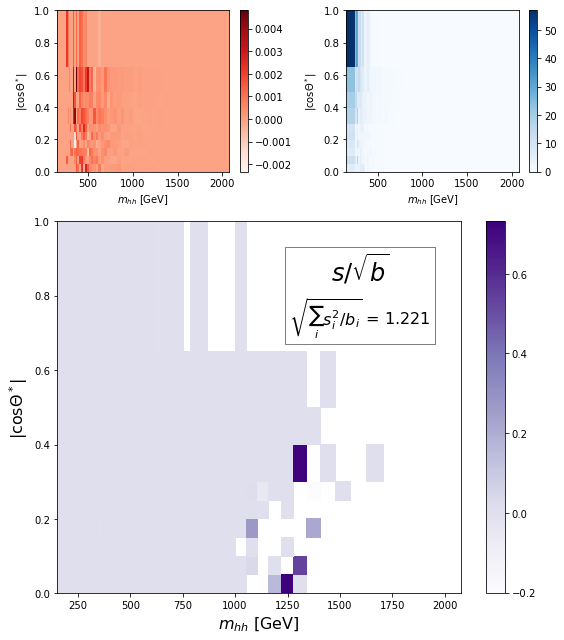

In [97]:
# But I think we want to calculate the significance *after* Xwt

cos_edges = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.65, 1])
nBins=[edges,cos_edges]

sj,bj  = plot2dSig(sdf[sig_mask&(sdf.kinematic_region==0)],
                   bdf[bkg_mask&(bdf.kinematic_region==0)],
                   'm_hh','cosThetaStar',nBins,None,w2b=w2b,
                   smText='',dataText='',ylabel='$|\cos \Theta^*|$')#,
                   #figDir='figures/dl1r_77',tag='_varBins')

## Lastly - the $\kappa_\lambda$ scan!!

In [119]:
subsetCols = [f'pT_{pT}{t}' for pT in pTs for t in ['','_cosThetaStar']]

index = pd.MultiIndex.from_tuples(itertools.product(subsetCols,bidx))
lambdas = np.arange(-20,21)

lims = pd.DataFrame(0,index,lambdas)

mu_max = 100
mu_tests_lmbda = np.concatenate((np.linspace(.01,.95,25),np.linspace(1,mu_max,4*mu_max)))

In [298]:
np.linspace(.01,.95,25)

array([0.01      , 0.04916667, 0.08833333, 0.1275    , 0.16666667,
       0.20583333, 0.245     , 0.28416667, 0.32333333, 0.3625    ,
       0.40166667, 0.44083333, 0.48      , 0.51916667, 0.55833333,
       0.5975    , 0.63666667, 0.67583333, 0.715     , 0.75416667,
       0.79333333, 0.8325    , 0.87166667, 0.91083333, 0.95      ])

In [121]:
# Get the lambda variations
getLambdaWeights(sdf)

In [290]:
sLambda, sLambda_cat = {l:[] for l in lambdas}, {l:[] for l in lambdas}
b, b_cat = [], []

for k, pT in enumerate(pTs[:2]):

    sig_mask = (sdf.ntag>=4) & (sdf.kinematic_region==0) & (sdf.pT_category == k)
    bkg_mask = (bdf.ntag==2) & (bdf.kinematic_region==0) & (bdf.pT_category == k)
    w2b = f'w_2b_pT_{pT}_nHidden_50'
    
    # Get the background histograms w/ and w/o the cosThetaStar Cateogorization
    bi,_    = np.histogram(bdf.loc[bkg_mask,'m_hh'], edges, weights=bdf.loc[bkg_mask,w2b])
    bj,_,_  = np.histogram2d(bdf.loc[bkg_mask,'m_hh'], np.abs(bdf.loc[bkg_mask,'cosThetaStar']), 
                             nBins, weights=bdf.loc[bkg_mask,w2b])
    
    b += list(bi)
    b_cat += list(bj.T.reshape(-1))
    
    # Loop over the lambdas and  get the limit
    for l in tqdm(lambdas):

        si,_ = np.histogram(sdf.loc[sig_mask,'m_hh'],edges, 
                            weights=sdf.loc[sig_mask,'w_lambda{}'.format(l)])
        sLambda[l] += list(hackHistogram(si))
        #lims.loc[f'pT_{pT}',l] = np.array(getExpectedBand(sLambda[l], b, mu_tests_lmbda))
        
        sj,_,_ = np.histogram2d(sdf.loc[sig_mask,'m_hh'], np.abs(sdf.loc[sig_mask,'cosThetaStar']),
                                nBins, weights=sdf.loc[sig_mask,'w_lambda{}'.format(l)])
        
        sLambda_cat[l] += list(hackHistogram(sj.T.reshape(-1)))
        
        lims.loc[f'pT_{pT}_cosThetaStar',l] = np.array(getExpectedBand(sLambda_cat[l], b_cat, mu_tests_lmbda))
        




  0%|          | 0/41 [00:00<?, ?it/s]/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/utils.py:168: RuntimeWarning: invalid value encountered in true_divide
  nullval = (qmu + qmu_A) / (2 * sqrtqmuA_v)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/

In [194]:
normFactor = np.array([np.sum(sdf.loc[(sdf.ntag>=4) & (sdf.pT_category == 0),'w_lambda{}'.format(l)]) for l in lambdas])
normFactor /= normFactor[21]
xsec = 31.05

# In pb, since this is what the ATLAS plot has
n = 0.001 * xsec * normFactor

In [292]:
stdText = '$\mathbf{ATLAS}$ Internal 2016 data\n'
stdText += r'$\sigma_{ggF}(pp \rightarrow HH)$ = '
stdText += "{:.2f} fb\n".format(xsec)
stdText += r'$HH\rightarrow 4b$ resolved analysis'
stdText += '\nStats only limit'

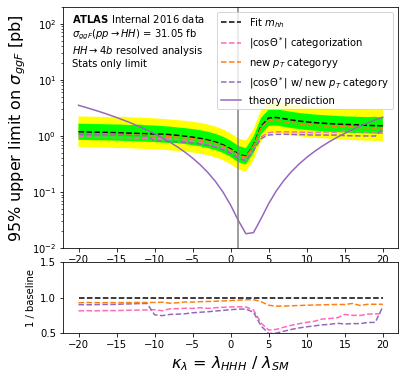

In [322]:
fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

ax.semilogy(lambdas, n * lims.loc[('pT_40','exp')],'k--',label='Fit $m_{hh}$')
ax.fill_between(lambdas, n * lims.loc[('pT_40','$-2\sigma$')], n * lims.loc[('pT_40','$+2\sigma$')],  facecolor = 'yellow')
ax.fill_between(lambdas, n * lims.loc[('pT_40','$-\sigma$')], n * lims.loc[('pT_40','$+\sigma$')],  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * lims.loc[('pT_40_cosThetaStar','exp')],
            color='hotpink',linestyle='--',label='$|\cos \Theta^*|$ categorization')
ax.semilogy(lambdas, n * lims.loc[('pT_30','exp')],
            color='C1',linestyle='--',label='new $p_T$ category')
ax.semilogy(lambdas, n * lims.loc[('pT_30_cosThetaStar','exp')],
            color='C4',linestyle='--',label='$|\cos \Theta^*|$ w/ new $p_T$ category')
#ax.semilogy(lambdas, n * lims.loc[('pT_20_cosThetaStar','exp')],color='g',linestyle='--',label='$|\cos \Theta^*|$ categorization with new $p_T \in$ (30,40) GeV category')

ax.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,200]
ax.plot([1]*2,ylim,'grey')
ax.set_ylim(ylim)

ax.set_ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)
ax.legend(loc='upper right')

ax2.plot(lambdas,lims.loc[('pT_40_cosThetaStar','exp')]/lims.loc[('pT_40','exp')],
         color='hotpink',linestyle='--')
ax2.plot(lambdas,lims.loc[('pT_30_cosThetaStar','exp')]/lims.loc[('pT_40','exp')],
         color='C4',linestyle='--')
ax2.plot(lambdas,lims.loc[('pT_30','exp')]/lims.loc[('pT_40','exp')],
         color='C1',linestyle='--')
# ax2.plot(lambdas,lims.loc[('pT_20_cosThetaStar','exp')]/lims.loc[('pT_40','exp')],
#          color='C2',linestyle='--')

ax2.plot(lambdas,np.ones_like(lambdas),'k--')

ax2.set_xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
ax2.set_ylabel('1 / baseline')
ax2.set_ylim(0.5,1.5)

ax.text(0.025,.975,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/kappa_lambda_scan_cosThetaStar_pTCat.pdf',bbox_inches='tight')

plt.show()

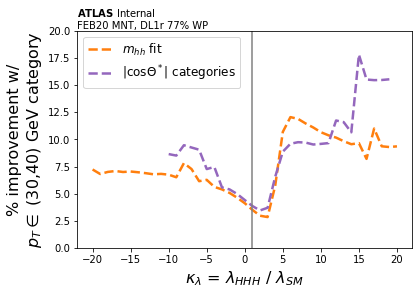

In [323]:
plt.plot(lambdas,100*(1-np.abs(lims.loc[('pT_30','exp')]/lims.loc[('pT_40','exp')])),
         'C1',linestyle='--',linewidth=2.5,label='$m_{hh}$ fit') 

y = 100*(1-np.abs(lims.loc[('pT_30_cosThetaStar','exp')]/lims.loc[('pT_40_cosThetaStar','exp')]))
plt.plot(lambdas[10:-1],y[10:-1],
         'C4',linestyle='--',linewidth=2.5,label='$|\cos \Theta^*|$ categories')

ylim = (0,20)
plt.plot([1]*2,ylim,'grey')

plt.ylim(ylim)

plt.xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$',fontsize=16)
plt.ylabel('% improvement w/\n'+r'$p_T \in$ (30,40) GeV category',fontsize=16)
plt.legend(fontsize=12)

ax=plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig('figures/lambdaRatio_pTCat.pdf',bbox_inches='tight')


plt.show()

In [201]:
stats

jet $p_T$ > 40 GeV  jet $p_T$ > 30 GeV  jet $p_T$ > 25 GeV  \
$-2\sigma$            8.160143            7.878433            7.858521   
$-\sigma$            10.967289           10.618852           10.588621   
exp                  15.326062           14.783584           14.742731   
$+\sigma$            21.476474           20.706915           20.647440   
$+2\sigma$           29.017244           27.963920           27.886381   

            Inclusive with $p_T$ > 30 GeV  
$-2\sigma$                       8.145163  
$-\sigma$                       10.947052  
exp                             15.279146  
$+\sigma$                       21.389205  
$+2\sigma$                      28.873515

In [285]:
lims.loc['pT_40',1]

$-2\sigma$     8.137986
$-\sigma$     10.963218
exp           15.301138
$+\sigma$     21.451218
$+2\sigma$    29.016093
Name: 1, dtype: float64

In [205]:
stats_cat

jet $p_T$ > 40 GeV  jet $p_T$ > 30 GeV  jet $p_T$ > 25 GeV
$-2\sigma$            7.105038            6.847999            6.801811
$-\sigma$             9.618001            9.243296            9.167597
exp                  13.444939           12.911990           12.831458
$+\sigma$            18.886264           18.163441           18.029087
$+2\sigma$           25.655653           24.653438           24.495539

In [295]:
lims.loc['pT_30_cosThetaStar',1]

$-2\sigma$     6.770990
$-\sigma$      9.150089
exp           12.813560
$+\sigma$     18.024048
$+2\sigma$    24.457241
Name: 1, dtype: float64

**Question:** How does additional categorization make the limit *worse*?

In [ ]:
plt.plot(s[:45],color='C4')
plt.plot(s1_cat,color='k',linestyle='--')
plt.show()

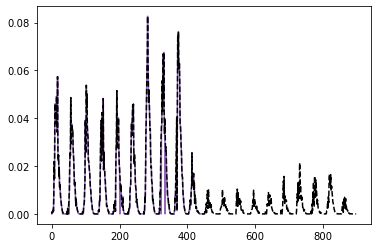

In [287]:
plt.plot(s_cat[:450],color='C4')
plt.plot(sLambda_cat[1],color='k',linestyle='--')
plt.show()

In [259]:
f = uproot.open('../data/LambdaWeightFile.root')
t = f['weight_lambda01']

In [271]:
t.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1.], dtype=float32)

In [265]:
edges

array([ 150,  250,  262,  275,  288,  302,  317,  332,  348,  365,  383,
        402,  422,  443,  465,  488,  512,  537,  563,  591,  620,  651,
        683,  717,  752,  789,  828,  869,  912,  957, 1004, 1054, 1106,
       1161, 1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884,
       1978, 2076])

In [269]:
t.edges

array([ 250.,  270.,  290.,  310.,  330.,  350.,  370.,  390.,  410.,
        430.,  450.,  470.,  490.,  510.,  530.,  550.,  570.,  590.,
        610.,  630.,  650.,  670.,  690.,  710.,  730.,  750.,  770.,
        790.,  810.,  830.,  850.,  870.,  890.,  910.,  930.,  950.,
        970.,  990., 1010., 1030., 1050., 1070., 1090., 1110., 1130.,
       1150., 1170., 1190., 1210., 1230., 1250., 1270., 1290., 1310.,
       1330., 1350., 1370., 1390., 1410., 1430., 1450., 1470., 1490.,
       1510., 1530., 1550., 1570., 1590., 1610., 1630., 1650., 1670.,
       1690., 1710., 1730., 1750., 1770., 1790., 1810., 1830., 1850.,
       1870., 1890., 1910., 1930., 1950., 1970., 1990., 2010., 2030.,
       2050.])

In [247]:
# plt.plot(b_cat[:450],color='C4')
# plt.plot(bkg_cat,color='k',linestyle='--')
# plt.show()

In [274]:
k,pT = 0, 40

sig_mask = (sdf.ntag>=4) & (sdf.kinematic_region==0) & (sdf.pT_category == k)
bkg_mask = (bdf.ntag==2) & (bdf.kinematic_region==0) & (bdf.pT_category == k)
w2b = f'w_2b_pT_{pT}_nHidden_50'

# Get the background histograms w/ and w/o the cosThetaStar Cateogorization
bi,_    = np.histogram(bdf.loc[bkg_mask,'m_hh'], edges, weights=bdf.loc[bkg_mask,w2b])
bj,_,_  = np.histogram2d(bdf.loc[bkg_mask,'m_hh'], bdf.loc[bkg_mask,'cosThetaStar'], 
                         nBins, weights=bdf.loc[bkg_mask,w2b])


In [250]:
si,_ = np.histogram(sdf.loc[sig_mask,'m_hh'], edges, weights=sdf.loc[sig_mask,'w_lambda1'])

In [273]:
plt.plot(s[:45],color='C4')
plt.plot(si,color='k',linestyle='--')
plt.plot(sj.sum(axis=1),color='b',linestyle='-.')
plt.show()

In [276]:
sj.shape

(45, 10)

In [278]:
si

array([ 2.79868936e-03,  3.33701769e-03,  7.76106899e-03,  1.45300003e-02,
        2.91577205e-02,  4.11589314e-02,  6.17153315e-02,  1.40186904e-01,
       -5.44294062e-03,  3.20303734e-01,  2.93509414e-01,  4.00822342e-01,
        4.32509955e-01,  4.39990852e-01,  4.90733309e-01,  4.03122770e-01,
        3.97339532e-01,  4.02150434e-01,  2.86530359e-01,  2.67545709e-01,
        2.01547592e-01,  1.82181574e-01,  1.73033308e-01,  1.43999750e-01,
        1.24841262e-01,  9.39284400e-02,  7.89516464e-02,  5.94520332e-02,
        4.36933185e-02,  3.68586615e-02,  2.94253146e-02,  1.90550517e-02,
        1.15350872e-02,  7.06222527e-03,  2.59396983e-03,  1.54983976e-03,
        7.02693505e-04,  2.48124181e-04,  1.41573447e-04,  3.11475374e-05,
        3.56955727e-05,  1.69093717e-05,  2.67181770e-06,  1.91299977e-06,
       -1.41978047e-06])

In [277]:
sj.sum(axis=1)

array([1.84823489e-03, 1.67254777e-03, 2.90513179e-03, 7.56147330e-03,
       1.27318817e-02, 2.11026584e-02, 3.78244492e-02, 6.21592888e-02,
       9.86448826e-02, 1.40312827e-01, 1.34622502e-01, 2.05917240e-01,
       2.13004531e-01, 2.16201112e-01, 2.42114319e-01, 1.89586590e-01,
       1.89667695e-01, 2.15606974e-01, 1.51258207e-01, 1.30839728e-01,
       1.02253211e-01, 9.29567315e-02, 7.95541250e-02, 7.39549184e-02,
       6.12935628e-02, 4.73362740e-02, 4.20279322e-02, 2.97920425e-02,
       1.95253066e-02, 1.92259946e-02, 1.63947662e-02, 1.00544944e-02,
       4.96200583e-03, 3.20954597e-03, 1.21157744e-03, 8.13620086e-04,
       3.80103653e-04, 1.47459360e-04, 6.62058468e-05, 1.92661627e-05,
       2.12878708e-05, 1.07011670e-05, 2.67181770e-06, 1.91299977e-06,
       0.00000000e+00])

In [282]:
np.sum(sj)

5.640649515199514

In [280]:
np.sum(si)

5.640649515199571

In [281]:
sj,_,_ = np.histogram2d(sdf.loc[sig_mask,'m_hh'], np.abs(sdf.loc[sig_mask,'cosThetaStar']),
                        [edges,cos_edges], weights=sdf.loc[sig_mask,'w_lambda1'])

s1_cat = hackHistogram(sj.T.reshape(-1))

In [242]:
getExpectedBand(s1_cat,b_cat[:450],mu_tests)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


[9.855538852430232,
 13.36846091295799,
 18.788374957688294,
 26.588970460324223,
 36.31289147195107]

In [238]:
sj.shape

(45, 10)

In [227]:
sj.T.shape

(10, 45)

In [240]:
sj[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.20368722e-03,  3.21103654e-03,  1.72513154e-02,
        1.07597285e-02,  1.77785716e-02,  2.08038465e-02,  1.99015156e-02,
        1.84173206e-02,  1.82351237e-02,  2.53054053e-02,  1.66863393e-02,
        1.52923934e-02,  4.14598151e-02,  1.42893915e-02,  1.08527901e-02,
        1.30851599e-02,  1.03489571e-02,  8.85504518e-03,  5.82970447e-03,
        5.86390199e-03,  4.27176877e-03,  3.84262232e-03,  2.49895891e-03,
        2.46374197e-03,  1.80622643e-03,  8.78536780e-04,  6.08182812e-04,
       -5.58110749e-04,  1.64317920e-04,  5.42835178e-05,  2.08593102e-05,
        1.74335152e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [239]:
hackHistogram(sj[:,0])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.20368722e-03, 3.21103654e-03, 1.72513154e-02,
       1.07597285e-02, 1.77785716e-02, 2.08038465e-02, 1.99015156e-02,
       1.84173206e-02, 1.82351237e-02, 2.53054053e-02, 1.66863393e-02,
       1.52923934e-02, 4.14598151e-02, 1.42893915e-02, 1.08527901e-02,
       1.30851599e-02, 1.03489571e-02, 8.85504518e-03, 5.82970447e-03,
       5.86390199e-03, 4.27176877e-03, 3.84262232e-03, 2.49895891e-03,
       2.46374197e-03, 1.80622643e-03, 8.78536780e-04, 6.08182812e-04,
       3.86250366e-04, 1.64317920e-04, 5.42835178e-05, 2.08593102e-05,
       1.74335152e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [229]:
sj.T.reshape(-1)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.84212266e-01,  7.60060797e-01,  2.55280388e+00,
        1.14763762e+00,  1.71306304e+00,  1.70188576e+00,  1.47948654e+00,
        1.13368283e+00,  9.82944209e-01,  1.22143236e+00,  6.76066328e-01,
        5.62459699e-01,  1.30105224e+00,  4.38749273e-01,  2.97663423e-01,
        3.22047577e-01,  2.39707809e-01,  2.08448927e-01,  1.42785047e-01,
        1.34589548e-01,  7.90038391e-02,  5.92180153e-02,  3.68191870e-02,
        2.93066725e-02,  2.12046639e-02,  7.09265951e-03,  5.44083517e-03,
        2.24023810e-03, -1.54272133e-04, -3.89129296e-04, -4.88317922e-04,
        4.68848784e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.65096791e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.64541826e-01,  3.65864740e-01,  5.70022761e-01,
        6.41321859e-01,  